In [10]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import qqplot
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')


In [11]:
# Data Cleaning
# Convert date columns to datetime
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

# Convert dates later than 7/17/2024 to 7/17/2024
cutoff_date = pd.Timestamp('2024-07-17')
customers_df['join_date'] = customers_df['join_date'].apply(lambda x: min(x, cutoff_date))
customers_df['last_purchase_date'] = customers_df['last_purchase_date'].apply(lambda x: min(x, cutoff_date))
marketing_df['campaign_date'] = marketing_df['campaign_date'].apply(lambda x: min(x, cutoff_date))
transactions_df['transaction_date'] = transactions_df['transaction_date'].apply(lambda x: min(x, cutoff_date))

# Impute 'unknown' for missing gender values
customers_df['gender'].fillna('unknown', inplace=True)

# Impute missing values in the Customers dataset using KNN for 'age'
imputer = KNNImputer(n_neighbors=5)
customers_df[['age']] = imputer.fit_transform(customers_df[['age']])

# Feature Engineering
# Calculate Recency, Frequency, and Monetary Value (RFM) features
cutoff_date = pd.Timestamp('2024-07-17')
rfm = transactions_df.groupby('customer_id').agg({
    'transaction_date': lambda x: (cutoff_date - x.max()).days,
    'transaction_id': 'count',
    'transaction_amount': 'sum'
}).reset_index()
rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Calculate the number of months from join date to last purchase date
customers_df['months_since_join'] = (customers_df['last_purchase_date'] - customers_df['join_date']).dt.days / 30
customers_df['months_since_join'].replace(0, 1, inplace=True)  # Avoid division by zero
customers_df['months_since_join'] = customers_df['months_since_join'].apply(lambda x: x if x > 1 else 1)

# Define CLV using the new formula
rfm['clv'] = rfm['monetary'] / customers_df['months_since_join']

# Merge RFM data with Customers data
merged_df = customers_df.merge(rfm, on='customer_id', how='left')

# Merge with Engagements data
merged_df = merged_df.merge(engagements_df, on='customer_id', how='left')

# Calculate the number of total responses to marketing campaigns
total_responses = marketing_df.groupby('customer_id').size().reset_index(name='total_responses')

# Merge with the Marketing data
merged_df = merged_df.merge(total_responses, on='customer_id', how='left')
merged_df['total_responses'].fillna(0, inplace=True)

# Calculate the number of positive responses to marketing campaigns
positive_responses_count = marketing_df[marketing_df['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='positive_responses')

# Merge with the positive responses data
merged_df = merged_df.merge(positive_responses_count, on='customer_id', how='left')
merged_df['positive_responses'].fillna(0, inplace=True)

# Feature Engineering for Engagements
# Replace 0 with 1 to avoid division by zero
merged_df['number_of_clicks'].replace(0, 1, inplace=True)
merged_df['number_of_emails_opened'].replace(0, 1, inplace=True)
merged_df['number_of_site_visits'].replace(0, 1, inplace=True)
merged_df['positive_responses'].replace(0, 1, inplace=True)

# Calculate transactions per click, email opened, site visit, and positive response
merged_df['transactions_per_click'] = merged_df['frequency'] / merged_df['number_of_clicks']
merged_df['transactions_per_email_opened'] = merged_df['frequency'] / merged_df['number_of_emails_opened']
merged_df['transactions_per_site_visit'] = merged_df['frequency'] / merged_df['number_of_site_visits']
merged_df['transactions_per_positive_response'] = merged_df['frequency'] / merged_df['positive_responses']

# Replace any remaining infinite values with NaN and drop rows with NaN in features
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(subset=['transactions_per_click', 'transactions_per_email_opened', 'transactions_per_site_visit', 'transactions_per_positive_response'], inplace=True)

# Sort customers by CLV and calculate cumulative CLV
merged_df = merged_df.sort_values(by='clv', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv'].cumsum()
total_clv = merged_df['clv'].sum()

# Label customers as 'high value' or 'low value'
merged_df['CLV_label'] = np.where(merged_df['cumulative_clv'] <= 0.8 * total_clv, 'High Value', 'Low Value')

# Convert CLV_label to binary
merged_df['CLV_label'] = np.where(merged_df['CLV_label'] == 'High Value', 1, 0)

C:\Users\NeilXu\AppData\Local\Temp\ipykernel_15636\3035948134.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers_df['gender'].fillna('unknown', inplace=True)
C:\Users\NeilXu\AppData\Local\Temp\ipykernel_15636\3035948134.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [12]:
# Prepare the data for linear regression
# Select the features and target variable
features = ['age', 'recency', 'frequency', 'transactions_per_click', 
            'transactions_per_email_opened', 'transactions_per_site_visit', 'transactions_per_positive_response', 'gender']
X = merged_df[features]
y = merged_df['clv']

# One-hot encode categorical variables, including 'unknown' for gender
X = pd.get_dummies(X, columns=['gender'], drop_first=True)

# Check for any remaining missing values in the data
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model using statsmodels' ols
train_data = X_train.copy()
train_data['clv'] = y_train
formula = 'clv ~ age + recency + frequency + transactions_per_click + transactions_per_email_opened + transactions_per_site_visit + transactions_per_positive_response + gender_Male + gender_unknown'
model = ols(formula=formula, data=train_data).fit()

# Print the model summary
print(model.summary())

# Train a Linear Regression model using sklearn's LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

# Evaluate the sklearn Linear Regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

                            OLS Regression Results                            
Dep. Variable:                    clv   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     3130.
Date:                Tue, 09 Jul 2024   Prob (F-statistic):               0.00
Time:                        18:57:22   Log-Likelihood:                -69144.
No. Observations:                8000   AIC:                         1.383e+05
Df Residuals:                    7990   BIC:                         1.384e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

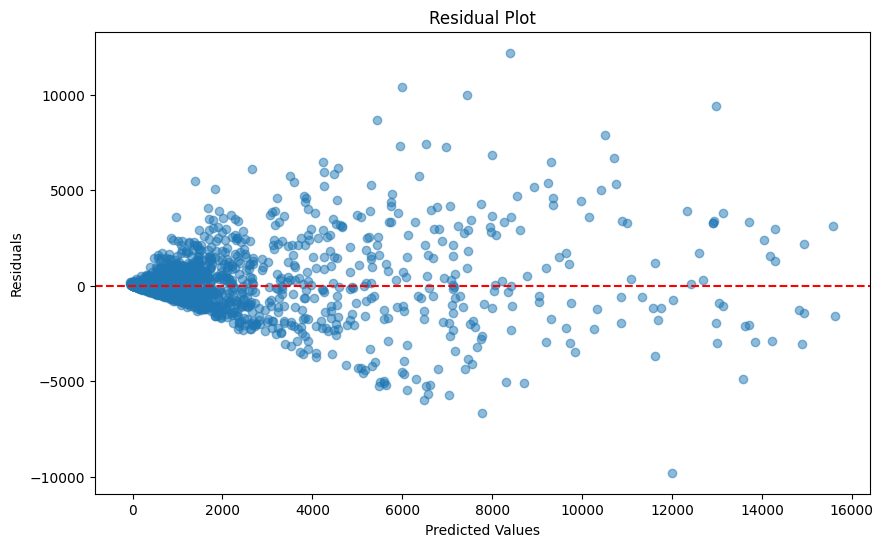

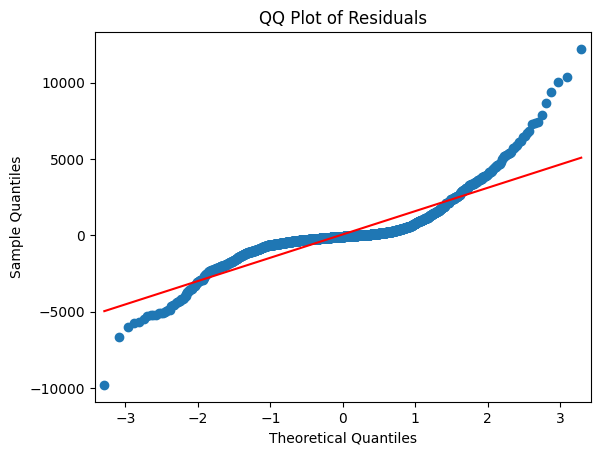

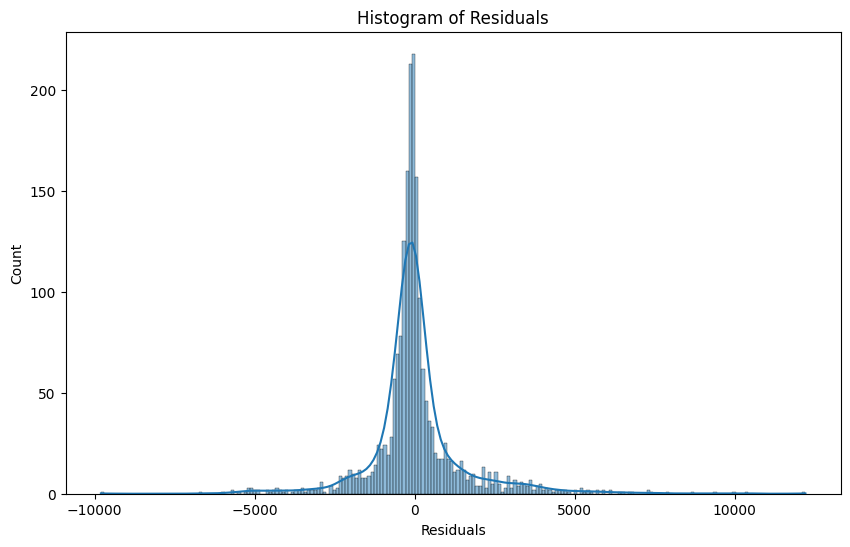

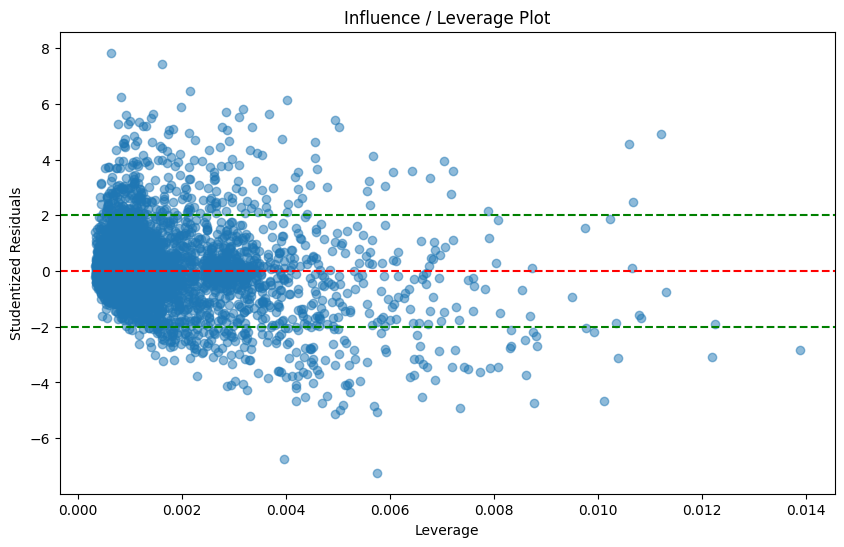

In [13]:
# Calculate residuals
residuals = y_test - y_pred

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# QQ-Plot
qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.show()

# Influence / Leverage Plot
influence = model.get_influence()
leverage = influence.hat_matrix_diag
residuals_studentized = influence.resid_studentized_internal

plt.figure(figsize=(10, 6))
plt.scatter(leverage, residuals_studentized, alpha=0.5)
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')
plt.title('Influence / Leverage Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=2, color='g', linestyle='--')
plt.axhline(y=-2, color='g', linestyle='--')
plt.show()